In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scienceplots
import matplotlib.animation as animation
from scipy.sparse import dok_matrix
import multiprocessing as mp
import scipy as sp
import matplotlib.ticker as ticker
import project

In [2]:
#General plot parameters and size definition
plt.style.use('science')
plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams.update({"axes.grid" : True})

In [3]:
def spikelet_fun(strength):
    return strength*  6.26066980e+01 - 1.44182439e-02

# Initial Raster plot - 5 neurons with no connection

In [4]:
#loading up the parameters

params_HH = project.utils.load_HH()
params_LIF = project.utils.load_LIF()
params_IZH = project.utils.load_ISH()
params_ML = project.utils.load_ML()

#time parameters
t_final = 1500
dt = 0.01



#Other constant parameters
num_neurons = 5
#Variation for the initial conditions
volt_var = np.random.normal(0,5,num_neurons)
y0_var = np.random.normal(0,5,num_neurons)
w0_var = np.random.normal(0,1,num_neurons)
u0_var = np.random.normal(0,1,num_neurons)
n0_var = np.random.normal(0,1,num_neurons)
m0_var = np.random.normal(0,1,num_neurons)
h0_var = np.random.normal(0,1,num_neurons)
Isyn = 0.0
tau = 0.65
V0 = -65 * np.ones(num_neurons) + volt_var
y0 = -65 * np.ones(num_neurons) + y0_var
w0 = 0 * np.ones(num_neurons) + w0_var
u0 = 0 * np.ones(num_neurons) + u0_var
n0 = 0 * np.ones(num_neurons) + n0_var
m0 = 0 * np.ones(num_neurons) + m0_var
h0 = 0 * np.ones(num_neurons) + h0_var
order = 2


#fixing random seed
np.random.seed(1234)

#generating the intensities
I_HH = np.zeros((int(t_final/dt),num_neurons))
I_IF = np.zeros((int(t_final/dt),num_neurons))
I_IZH = np.zeros((int(t_final/dt),num_neurons))
I_ML = np.zeros((int(t_final/dt),num_neurons))

for i in range(0,num_neurons):
    I_HH[:,i] = 2.5
    I_IF[:,i] = 2.5 
    I_IZH[:,i] = 2.5
    I_ML[:,i] = 2.5

In [5]:
#Creating the Electrical and Chemical connectivity matrices, in this case for 10 neurons
E_matrix,seed = project.utils.create_matrix('electrical',num_neurons,connection_fraction_e=1)
C_matrix, seed = project.utils.create_matrix('chemical',num_neurons,connection_fraction_c=1)

In [6]:
dataHH_adjust, completeHH_adjust, matrixHH_adjust, synaptic_HH = project.models.HH_Neuron_Network(dt,t_final,order,V0,n0,m0,h0,*params_HH,I_HH,Isyn,0.0,tau,E_matrix,C_matrix)
dataIF_adjust, completeIF_adjust, matrixIF_adjust, synaptic_IF = project.models.LIF_Neuron_Network(dt, t_final,order,y0,*params_LIF,I_IF,Isyn,0.0,tau,0,E_matrix,C_matrix)
dataIZH_adjust, completeIZH_adjust, matrixIZH_adjust, synaptic_IZH = project.models.IZH_Neuron_Network(dt,t_final,order,y0,u0,I_IZH,Isyn,*params_IZH,0.0,tau,E_matrix,C_matrix)
dataML_adjust, completeML_adjust, matrixML_adjust, synaptic_ML = project.models.ML_Neuron_Network(dt,t_final,2,y0,w0,*params_ML,I_ML,Isyn,0.00,tau,E_matrix,C_matrix)

(0.0, 60.0)

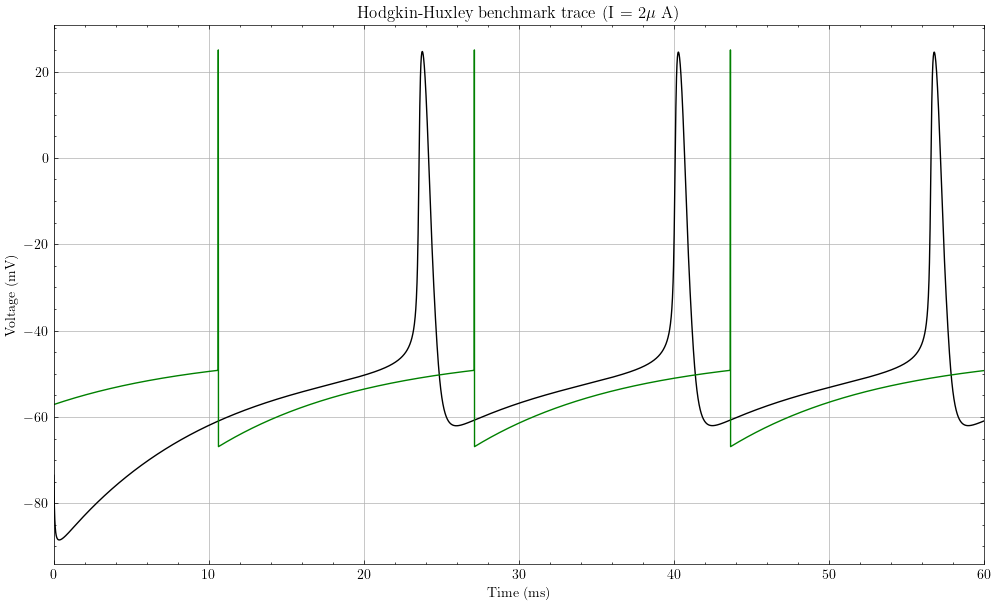

In [7]:
time = np.linspace(0,t_final,int(t_final/dt),)
plt.plot(time,dataHH_adjust[:,4], color = 'black')
plt.plot(time,dataIF_adjust[:,4], color = 'green')
plt.title(r'Hodgkin-Huxley benchmark trace (I = 2$\mu$ A)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.xlim(000,60)

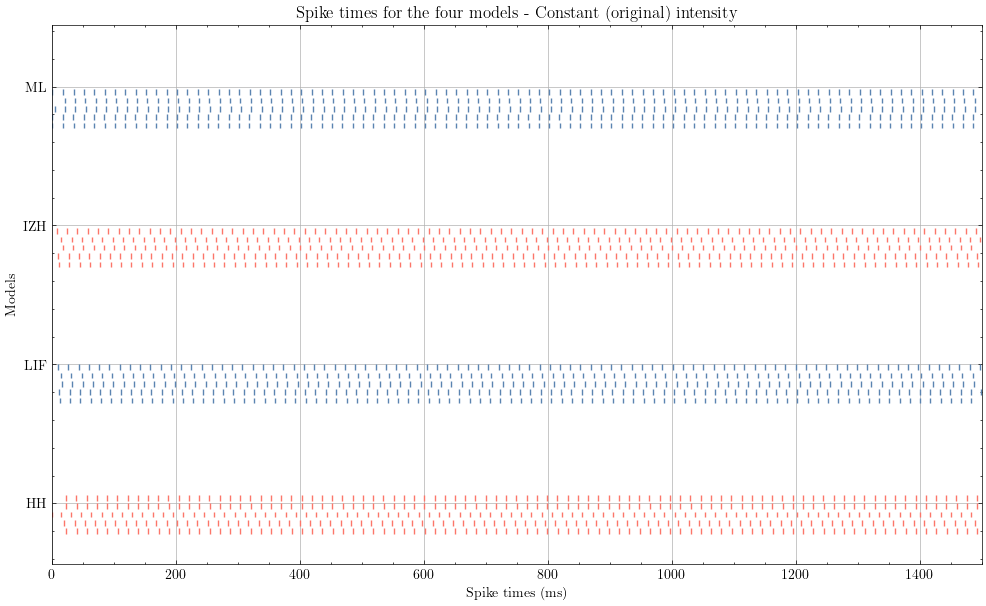

In [8]:
spike_HH_1 =  (np.argwhere(np.array(matrixHH_adjust.todense())[0,:]>0) * dt).flatten()
spike_HH_2 =  (np.argwhere(np.array(matrixHH_adjust.todense())[1,:]>0) * dt).flatten()
spike_HH_3 =  (np.argwhere(np.array(matrixHH_adjust.todense())[2,:]>0) * dt).flatten()
spike_HH_4 =  (np.argwhere(np.array(matrixHH_adjust.todense())[3,:]>0) * dt).flatten()
spike_HH_5 =  (np.argwhere(np.array(matrixHH_adjust.todense())[4,:]>0) * dt).flatten()
#spike_HH_6 =  (np.argwhere(np.array(matrixHH_adjust.todense())[5,:]>0) * dt).flatten()
#spike_HH_7 =  (np.argwhere(np.array(matrixHH_adjust.todense())[6,:]>0) * dt).flatten()
#spike_HH_8 =  (np.argwhere(np.array(matrixHH_adjust.todense())[7,:]>0) * dt).flatten()
#spike_HH_9 =  (np.argwhere(np.array(matrixHH_adjust.todense())[8,:]>0) * dt).flatten()
#spike_HH_10 =  (np.argwhere(np.array(matrixHH_adjust.todense())[9,:]>0) * dt).flatten()

spike_IF_1 =  (np.argwhere(np.array(matrixIF_adjust.todense())[0,:]>0) * dt).flatten()
spike_IF_2 =  (np.argwhere(np.array(matrixIF_adjust.todense())[1,:]>0) * dt).flatten()
spike_IF_3 =  (np.argwhere(np.array(matrixIF_adjust.todense())[2,:]>0) * dt).flatten()
spike_IF_4 =  (np.argwhere(np.array(matrixIF_adjust.todense())[3,:]>0) * dt).flatten()
spike_IF_5 =  (np.argwhere(np.array(matrixIF_adjust.todense())[4,:]>0) * dt).flatten()
#spike_IF_6 =  (np.argwhere(np.array(matrixIF_adjust.todense())[5,:]>0) * dt).flatten()
#spike_IF_7 =  (np.argwhere(np.array(matrixIF_adjust.todense())[6,:]>0) * dt).flatten()
#spike_IF_8 =  (np.argwhere(np.array(matrixIF_adjust.todense())[7,:]>0) * dt).flatten()
#spike_IF_9 =  (np.argwhere(np.array(matrixIF_adjust.todense())[8,:]>0) * dt).flatten()
#spike_IF_10 =  (np.argwhere(np.array(matrixIF_adjust.todense())[9,:]>0) * dt).flatten()

spike_IZH_1 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[0,:]>0) * dt).flatten()
spike_IZH_2 = (np.argwhere(np.array(matrixIZH_adjust.todense())[1,:]>0) * dt).flatten()
spike_IZH_3 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[2,:]>0) * dt).flatten()
spike_IZH_4 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[3,:]>0) * dt).flatten()
spike_IZH_5 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[4,:]>0) * dt).flatten()
#spike_IZH_6 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[5,:]>0) * dt).flatten()
#spike_IZH_7 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[6,:]>0) * dt).flatten()
#spike_IZH_8 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[7,:]>0) * dt).flatten()
#spike_IZH_9 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[8,:]>0) * dt).flatten()
#spike_IZH_10 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[9,:]>0) * dt).flatten()

spike_ML_1 = (np.argwhere(np.array(matrixML_adjust.todense())[0,:]>0) * dt).flatten()
spike_ML_2 = (np.argwhere(np.array(matrixML_adjust.todense())[1,:]>0) * dt).flatten()
spike_ML_3 =  (np.argwhere(np.array(matrixML_adjust.todense())[2,:]>0) * dt).flatten()
spike_ML_4 =  (np.argwhere(np.array(matrixML_adjust.todense())[3,:]>0) * dt).flatten()
spike_ML_5 =  (np.argwhere(np.array(matrixML_adjust.todense())[4,:]>0) * dt).flatten()
#spike_ML_6 =  (np.argwhere(np.array(matrixML_adjust.todense())[5,:]>0) * dt).flatten()
#spike_ML_7 =  (np.argwhere(np.array(matrixML_adjust.todense())[6,:]>0) * dt).flatten()
#spike_ML_8 =  (np.argwhere(np.array(matrixML_adjust.todense())[7,:]>0) * dt).flatten()
#spike_ML_9 =  (np.argwhere(np.array(matrixML_adjust.todense())[8,:]>0) * dt).flatten()
#spike_ML_10 =  (np.argwhere(np.array(matrixML_adjust.todense())[9,:]>0) * dt).flatten()

fig, ax = plt.subplots()

ax.eventplot(spike_HH_1, color = '#FC766AFF', linelengths=0.1, lineoffsets=0)
ax.eventplot(spike_HH_2,color='#FC766AFF',lineoffsets=0.15,linelengths=0.1)
ax.eventplot(spike_HH_3, color = '#FC766AFF', lineoffsets = 0.3, linelengths=0.1)
ax.eventplot(spike_HH_4, color = '#FC766AFF', lineoffsets = 0.45, linelengths=0.1)
ax.eventplot(spike_HH_5, color = '#FC766AFF', lineoffsets = 0.60, linelengths=0.1)
#ax.eventplot(spike_HH_6, color = '#FC766AFF', lineoffsets = 0.75, linelengths=0.1)
#ax.eventplot(spike_HH_7, color = '#FC766AFF', lineoffsets = 0.90, linelengths=0.1)
#ax.eventplot(spike_HH_8, color = '#FC766AFF', lineoffsets = 1.05, linelengths=0.1)
#ax.eventplot(spike_HH_9, color = '#FC766AFF', lineoffsets = 1.2, linelengths=0.1)
#ax.eventplot(spike_HH_10, color = '#FC766AFF', lineoffsets = 1.35, linelengths=0.1)


ax.eventplot(spike_IF_2,color = '#5B84B1FF',lineoffsets=2.5, linelengths=0.1)
ax.eventplot(spike_IF_1, color = '#5B84B1FF', lineoffsets= 2.35, linelengths=0.1)
ax.eventplot(spike_IF_3, color ='#5B84B1FF', lineoffsets= 2.65, linelengths=0.1)
ax.eventplot(spike_IF_4, color = '#5B84B1FF', lineoffsets= 2.80, linelengths=0.1)
ax.eventplot(spike_IF_5, color = '#5B84B1FF', lineoffsets= 2.95, linelengths=0.1)
#ax.eventplot(spike_IF_6, color ='#5B84B1FF', lineoffsets= 3.1, linelengths=0.1)
#ax.eventplot(spike_IF_7, color = '#5B84B1FF', lineoffsets= 3.25, linelengths=0.1)
#ax.eventplot(spike_IF_8, color = '#5B84B1FF', lineoffsets= 3.40, linelengths=0.1)
#ax.eventplot(spike_IF_9, color = '#5B84B1FF', lineoffsets= 3.55, linelengths=0.1)
#ax.eventplot(spike_IF_10, color = '#5B84B1FF', lineoffsets= 3.70, linelengths=0.1)


ax.eventplot(spike_IZH_2,color = '#FC766AFF',lineoffsets= 5.15-0.2, linelengths=0.1 )
ax.eventplot(spike_IZH_1, color = '#FC766AFF', lineoffsets= 5.0-0.2, linelengths=0.1)
ax.eventplot(spike_IZH_3,color = '#FC766AFF',lineoffsets= 5.3-0.2, linelengths=0.1 )
ax.eventplot(spike_IZH_4,color = '#FC766AFF',lineoffsets= 5.45-0.2, linelengths=0.1 )
ax.eventplot(spike_IZH_5,color = '#FC766AFF',lineoffsets= 5.6-0.2, linelengths=0.1 )
#ax.eventplot(spike_IZH_6,color = '#FC766AFF',lineoffsets= 5.75-0.2, linelengths=0.1 )
#ax.eventplot(spike_IZH_7,color = '#FC766AFF',lineoffsets= 5.9-0.2, linelengths=0.1 )
#ax.eventplot(spike_IZH_8,color = '#FC766AFF',lineoffsets= 6.05-0.2, linelengths=0.1 )
#ax.eventplot(spike_IZH_9,color = '#FC766AFF',lineoffsets= 6.2-0.2, linelengths=0.1 )
#ax.eventplot(spike_IZH_10,color = '#FC766AFF',lineoffsets= 6.35-0.2, linelengths=0.1 )


ax.eventplot(spike_ML_2, color = '#5B84B1FF', lineoffsets= 7.65-0.2, linelengths=0.1)
ax.eventplot(spike_ML_1,color = '#5B84B1FF', lineoffsets= 7.5-0.2, linelengths=0.1)
ax.eventplot(spike_ML_3,color = '#5B84B1FF', lineoffsets= 7.80-0.2, linelengths=0.1)
ax.eventplot(spike_ML_4,color = '#5B84B1FF', lineoffsets= 7.95-0.2, linelengths=0.1)
ax.eventplot(spike_ML_5,color = '#5B84B1FF', lineoffsets= 8.1-0.2, linelengths=0.1)
#ax.eventplot(spike_ML_6,color = '#5B84B1FF', lineoffsets= 8.25-0.2, linelengths=0.1)
#ax.eventplot(spike_ML_7,color = '#5B84B1FF', lineoffsets= 8.4-0.2, linelengths=0.1)
#ax.eventplot(spike_ML_8,color = '#5B84B1FF', lineoffsets= 8.55-0.2, linelengths=0.1)
#ax.eventplot(spike_ML_9,color = '#5B84B1FF', lineoffsets= 8.7-0.2, linelengths=0.1)
#ax.eventplot(spike_ML_10,color = '#5B84B1FF', lineoffsets= 8.85-0.2, linelengths=0.1)


ax.set_ylim(-0.6,9.1)
ax.set_ylabel('Models')
plt.yticks((0.5,3.0,5.5,8.0))
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = 'HH'
labels[1] = 'LIF'
labels[2] = 'IZH'
labels[3] = 'ML'

ax.set_yticklabels(labels, color = 'black')
ax.set_xlabel('Spike times (ms)')
ax.set_xlim(0,1500)

plt.title('Spike times for the four models - Constant (original) intensity')
plt.show()

In [9]:
firing_HH_pre = len(spike_HH_1)  * 1000 / t_final 
firing_HH_post = len(spike_HH_2)   *1000 / t_final
firing_IF_pre = len(spike_IF_1)  * 1000 / t_final 
firing_IF_post = len(spike_IF_2)  *1000 / t_final
firing_IZH_pre = len(spike_IZH_1)  * 1000 / t_final 
firing_IZH_post = len(spike_IZH_2)  *1000 / t_final
firing_ML_pre = len(spike_ML_1)  * 1000 / t_final 
firing_ML_post = len(spike_ML_2) *1000 / t_final

print('Pre-synaptic firing rates \n HH:',firing_HH_pre,'IF:',firing_IF_pre, 'IZH:', firing_IZH_pre, 'ML:', firing_ML_pre )
print('Post-synaptic firing rates \n HH:',firing_HH_post,'IF:',firing_IF_post, 'IZH:', firing_IZH_post, 'ML:', firing_ML_post )


Pre-synaptic firing rates 
 HH: 60.0 IF: 60.0 IZH: 60.0 ML: 60.0
Post-synaptic firing rates 
 HH: 60.0 IF: 60.666666666666664 IZH: 60.0 ML: 60.0


# Second Raster plot - Gap Junctions turned on and random intensity

In [10]:
#loading up the parameters
params_HH = project.utils.load_HH()
params_LIF = project.utils.load_LIF()
params_IZH = project.utils.load_ISH()
params_ML = project.utils.load_ML()

#time parameters
t_final = 1500
dt = 0.01


num_neurons = 5
#Variation for the initial conditions
volt_var = np.random.normal(0,5,num_neurons)
y0_var = np.random.normal(0,5,num_neurons)
w0_var = np.random.normal(0,1,num_neurons)
u0_var = np.random.normal(0,1,num_neurons)
n0_var = np.random.normal(0,1,num_neurons)
m0_var = np.random.normal(0,1,num_neurons)
h0_var = np.random.normal(0,1,num_neurons)
Isyn = 0.0
tau = 0.65
V0 = -65 * np.ones(num_neurons) + volt_var
y0 = -65 * np.ones(num_neurons) + y0_var
w0 = 0 * np.ones(num_neurons) + w0_var
u0 = 0 * np.ones(num_neurons) + u0_var
n0 = 0 * np.ones(num_neurons) + n0_var
m0 = 0 * np.ones(num_neurons) + m0_var
h0 = 0 * np.ones(num_neurons) + h0_var
order = 2


#fixing random seed
np.random.seed(1234)

#generating the intensities
I_HH = np.zeros((int(t_final/dt),num_neurons))
I_IF = np.zeros((int(t_final/dt),num_neurons))
I_IZH = np.zeros((int(t_final/dt),num_neurons))
I_ML = np.zeros((int(t_final/dt),num_neurons))



for i in range(0,num_neurons):
    x_normal = np.random.normal(0,5,int(t_final/dt))
    x_if = np.random.normal(0,1.5,int(t_final/dt))
    I_HH[:,i] = 2.5 * (1 + 1*x_normal)
    I_IF[:,i] = 2.5 * (1 + 1*x_if)
    I_IZH[:,i] = 2.5 * (1 + 1*x_normal)
    I_ML[:,i] = 2.5 * (1+ 1*x_normal)

In [11]:
#Creating the Electrical and Chemical connectivity matrices, in this case for 10 neurons
E_matrix,seed = project.utils.create_matrix('electrical',num_neurons,connection_fraction_e=1)
C_matrix, seed = project.utils.create_matrix('chemical',num_neurons,connection_fraction_c=1)

In [12]:
dataHH_adjust, completeHH_adjust, matrixHH_adjust, synaptic_HH = project.models.HH_Neuron_Network(dt,t_final,order,V0,n0,m0,h0,*params_HH,I_HH,Isyn,0.012,tau,E_matrix,C_matrix)
dataIF_adjust, completeIF_adjust, matrixIF_adjust, synaptic_IF = project.models.LIF_Neuron_Network(dt, t_final,order,y0,*params_LIF,I_IF,Isyn,0.012,tau,1,E_matrix,C_matrix)
dataIZH_adjust, completeIZH_adjust, matrixIZH_adjust, synaptic_IZH = project.models.IZH_Neuron_Network(dt,t_final,order,y0,u0,I_IZH,Isyn,*params_IZH,0.04,tau,E_matrix,C_matrix)
dataML_adjust, completeML_adjust, matrixML_adjust, synaptic_ML = project.models.ML_Neuron_Network(dt,t_final,2,y0,w0,*params_ML,I_ML,Isyn,0.008,tau,E_matrix,C_matrix)

(1200.0, 1500.0)

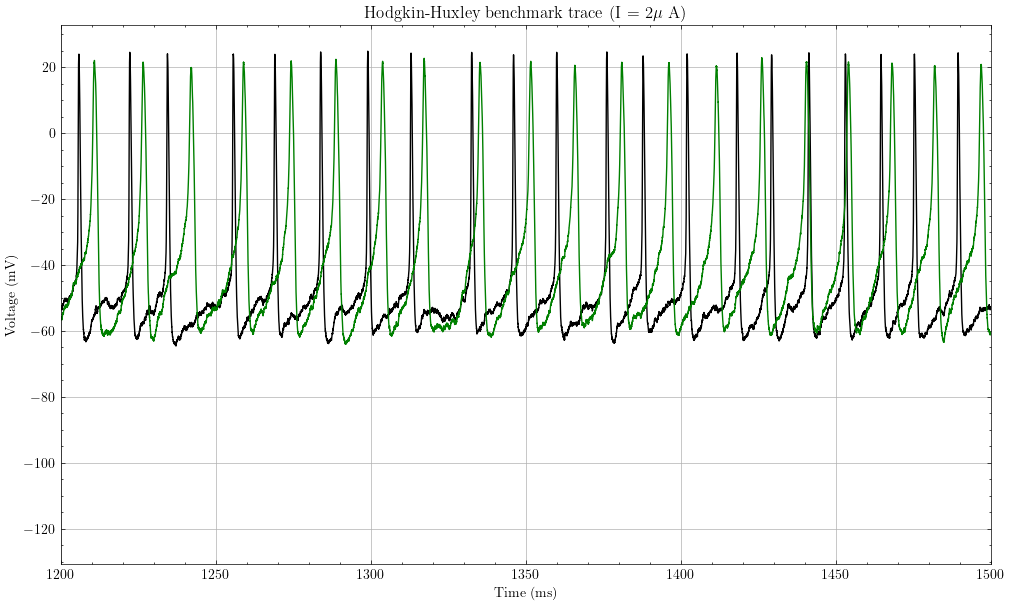

In [13]:
time = np.linspace(0,t_final,int(t_final/dt),)
plt.plot(time,dataHH_adjust[:,4], color = 'black')
plt.plot(time,dataML_adjust[:,4], color = 'green')
plt.title(r'Hodgkin-Huxley benchmark trace (I = 2$\mu$ A)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.xlim(1200,1500)

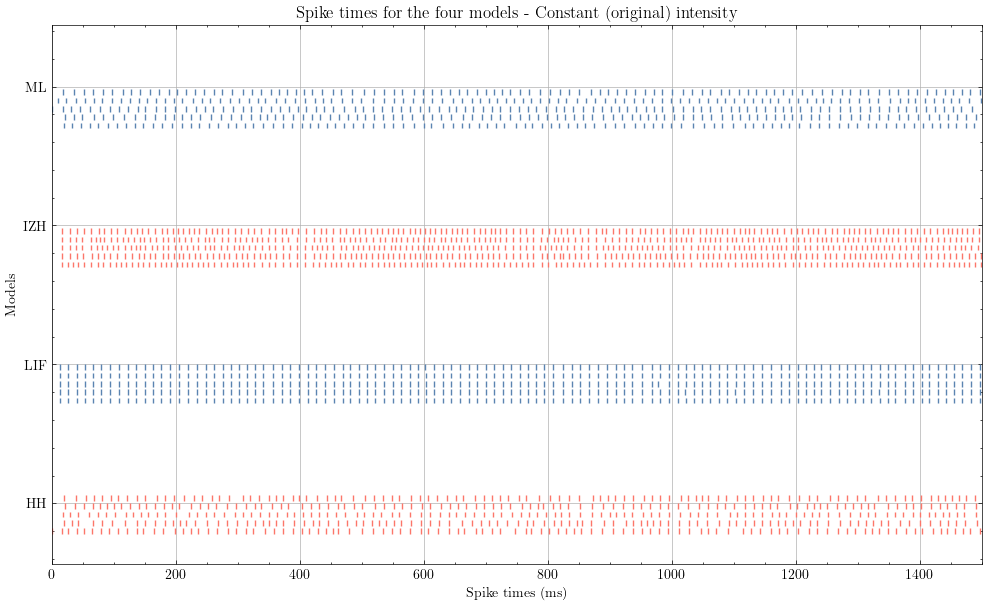

In [14]:
spike_HH_1 =  (np.argwhere(np.array(matrixHH_adjust.todense())[0,:]>0) * dt).flatten()
spike_HH_2 =  (np.argwhere(np.array(matrixHH_adjust.todense())[1,:]>0) * dt).flatten()
spike_HH_3 =  (np.argwhere(np.array(matrixHH_adjust.todense())[2,:]>0) * dt).flatten()
spike_HH_4 =  (np.argwhere(np.array(matrixHH_adjust.todense())[3,:]>0) * dt).flatten()
spike_HH_5 =  (np.argwhere(np.array(matrixHH_adjust.todense())[4,:]>0) * dt).flatten()
#spike_HH_6 =  (np.argwhere(np.array(matrixHH_adjust.todense())[5,:]>0) * dt).flatten()
#spike_HH_7 =  (np.argwhere(np.array(matrixHH_adjust.todense())[6,:]>0) * dt).flatten()
#spike_HH_8 =  (np.argwhere(np.array(matrixHH_adjust.todense())[7,:]>0) * dt).flatten()
#spike_HH_9 =  (np.argwhere(np.array(matrixHH_adjust.todense())[8,:]>0) * dt).flatten()
#spike_HH_10 =  (np.argwhere(np.array(matrixHH_adjust.todense())[9,:]>0) * dt).flatten()

spike_IF_1 =  (np.argwhere(np.array(matrixIF_adjust.todense())[0,:]>0) * dt).flatten()
spike_IF_2 =  (np.argwhere(np.array(matrixIF_adjust.todense())[1,:]>0) * dt).flatten()
spike_IF_3 =  (np.argwhere(np.array(matrixIF_adjust.todense())[2,:]>0) * dt).flatten()
spike_IF_4 =  (np.argwhere(np.array(matrixIF_adjust.todense())[3,:]>0) * dt).flatten()
spike_IF_5 =  (np.argwhere(np.array(matrixIF_adjust.todense())[4,:]>0) * dt).flatten()
#spike_IF_6 =  (np.argwhere(np.array(matrixIF_adjust.todense())[5,:]>0) * dt).flatten()
#spike_IF_7 =  (np.argwhere(np.array(matrixIF_adjust.todense())[6,:]>0) * dt).flatten()
#spike_IF_8 =  (np.argwhere(np.array(matrixIF_adjust.todense())[7,:]>0) * dt).flatten()
#spike_IF_9 =  (np.argwhere(np.array(matrixIF_adjust.todense())[8,:]>0) * dt).flatten()
#spike_IF_10 =  (np.argwhere(np.array(matrixIF_adjust.todense())[9,:]>0) * dt).flatten()

spike_IZH_1 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[0,:]>0) * dt).flatten()
spike_IZH_2 = (np.argwhere(np.array(matrixIZH_adjust.todense())[1,:]>0) * dt).flatten()
spike_IZH_3 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[2,:]>0) * dt).flatten()
spike_IZH_4 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[3,:]>0) * dt).flatten()
spike_IZH_5 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[4,:]>0) * dt).flatten()
#spike_IZH_6 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[5,:]>0) * dt).flatten()
#spike_IZH_7 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[6,:]>0) * dt).flatten()
#spike_IZH_8 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[7,:]>0) * dt).flatten()
#spike_IZH_9 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[8,:]>0) * dt).flatten()
#spike_IZH_10 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[9,:]>0) * dt).flatten()

spike_ML_1 = (np.argwhere(np.array(matrixML_adjust.todense())[0,:]>0) * dt).flatten()
spike_ML_2 = (np.argwhere(np.array(matrixML_adjust.todense())[1,:]>0) * dt).flatten()
spike_ML_3 =  (np.argwhere(np.array(matrixML_adjust.todense())[2,:]>0) * dt).flatten()
spike_ML_4 =  (np.argwhere(np.array(matrixML_adjust.todense())[3,:]>0) * dt).flatten()
spike_ML_5 =  (np.argwhere(np.array(matrixML_adjust.todense())[4,:]>0) * dt).flatten()
#spike_ML_6 =  (np.argwhere(np.array(matrixML_adjust.todense())[5,:]>0) * dt).flatten()
#spike_ML_7 =  (np.argwhere(np.array(matrixML_adjust.todense())[6,:]>0) * dt).flatten()
#spike_ML_8 =  (np.argwhere(np.array(matrixML_adjust.todense())[7,:]>0) * dt).flatten()
#spike_ML_9 =  (np.argwhere(np.array(matrixML_adjust.todense())[8,:]>0) * dt).flatten()
#spike_ML_10 =  (np.argwhere(np.array(matrixML_adjust.todense())[9,:]>0) * dt).flatten()

fig, ax = plt.subplots()

ax.eventplot(spike_HH_1, color = '#FC766AFF', linelengths=0.1, lineoffsets=0)
ax.eventplot(spike_HH_2,color='#FC766AFF',lineoffsets=0.15,linelengths=0.1)
ax.eventplot(spike_HH_3, color = '#FC766AFF', lineoffsets = 0.3, linelengths=0.1)
ax.eventplot(spike_HH_4, color = '#FC766AFF', lineoffsets = 0.45, linelengths=0.1)
ax.eventplot(spike_HH_5, color = '#FC766AFF', lineoffsets = 0.60, linelengths=0.1)
#ax.eventplot(spike_HH_6, color = '#FC766AFF', lineoffsets = 0.75, linelengths=0.1)
#ax.eventplot(spike_HH_7, color = '#FC766AFF', lineoffsets = 0.90, linelengths=0.1)
#ax.eventplot(spike_HH_8, color = '#FC766AFF', lineoffsets = 1.05, linelengths=0.1)
#ax.eventplot(spike_HH_9, color = '#FC766AFF', lineoffsets = 1.2, linelengths=0.1)
#ax.eventplot(spike_HH_10, color = '#FC766AFF', lineoffsets = 1.35, linelengths=0.1)


ax.eventplot(spike_IF_2,color = '#5B84B1FF',lineoffsets=2.5, linelengths=0.1)
ax.eventplot(spike_IF_1, color = '#5B84B1FF', lineoffsets= 2.35, linelengths=0.1)
ax.eventplot(spike_IF_3, color ='#5B84B1FF', lineoffsets= 2.65, linelengths=0.1)
ax.eventplot(spike_IF_4, color = '#5B84B1FF', lineoffsets= 2.80, linelengths=0.1)
ax.eventplot(spike_IF_5, color = '#5B84B1FF', lineoffsets= 2.95, linelengths=0.1)
#ax.eventplot(spike_IF_6, color ='#5B84B1FF', lineoffsets= 3.1, linelengths=0.1)
#ax.eventplot(spike_IF_7, color = '#5B84B1FF', lineoffsets= 3.25, linelengths=0.1)
#ax.eventplot(spike_IF_8, color = '#5B84B1FF', lineoffsets= 3.40, linelengths=0.1)
#ax.eventplot(spike_IF_9, color = '#5B84B1FF', lineoffsets= 3.55, linelengths=0.1)
#ax.eventplot(spike_IF_10, color = '#5B84B1FF', lineoffsets= 3.70, linelengths=0.1)


ax.eventplot(spike_IZH_2,color = '#FC766AFF',lineoffsets= 5.15-0.2, linelengths=0.1 )
ax.eventplot(spike_IZH_1, color = '#FC766AFF', lineoffsets= 5.0-0.2, linelengths=0.1)
ax.eventplot(spike_IZH_3,color = '#FC766AFF',lineoffsets= 5.3-0.2, linelengths=0.1 )
ax.eventplot(spike_IZH_4,color = '#FC766AFF',lineoffsets= 5.45-0.2, linelengths=0.1 )
ax.eventplot(spike_IZH_5,color = '#FC766AFF',lineoffsets= 5.6-0.2, linelengths=0.1 )
#ax.eventplot(spike_IZH_6,color = '#FC766AFF',lineoffsets= 5.75-0.2, linelengths=0.1 )
#ax.eventplot(spike_IZH_7,color = '#FC766AFF',lineoffsets= 5.9-0.2, linelengths=0.1 )
#ax.eventplot(spike_IZH_8,color = '#FC766AFF',lineoffsets= 6.05-0.2, linelengths=0.1 )
#ax.eventplot(spike_IZH_9,color = '#FC766AFF',lineoffsets= 6.2-0.2, linelengths=0.1 )
#ax.eventplot(spike_IZH_10,color = '#FC766AFF',lineoffsets= 6.35-0.2, linelengths=0.1 )


ax.eventplot(spike_ML_2, color = '#5B84B1FF', lineoffsets= 7.65-0.2, linelengths=0.1)
ax.eventplot(spike_ML_1,color = '#5B84B1FF', lineoffsets= 7.5-0.2, linelengths=0.1)
ax.eventplot(spike_ML_3,color = '#5B84B1FF', lineoffsets= 7.80-0.2, linelengths=0.1)
ax.eventplot(spike_ML_4,color = '#5B84B1FF', lineoffsets= 7.95-0.2, linelengths=0.1)
ax.eventplot(spike_ML_5,color = '#5B84B1FF', lineoffsets= 8.1-0.2, linelengths=0.1)
#ax.eventplot(spike_ML_6,color = '#5B84B1FF', lineoffsets= 8.25-0.2, linelengths=0.1)
#ax.eventplot(spike_ML_7,color = '#5B84B1FF', lineoffsets= 8.4-0.2, linelengths=0.1)
##ax.eventplot(spike_ML_8,color = '#5B84B1FF', lineoffsets= 8.55-0.2, linelengths=0.1)
#ax.eventplot(spike_ML_9,color = '#5B84B1FF', lineoffsets= 8.7-0.2, linelengths=0.1)
#ax.eventplot(spike_ML_10,color = '#5B84B1FF', lineoffsets= 8.85-0.2, linelengths=0.1)


ax.set_ylim(-0.6,9.1)
ax.set_ylabel('Models')
plt.yticks((0.5,3.0,5.5,8.0))
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = 'HH'
labels[1] = 'LIF'
labels[2] = 'IZH'
labels[3] = 'ML'

ax.set_yticklabels(labels, color = 'black')
ax.set_xlabel('Spike times (ms)')
ax.set_xlim(0,1500)

plt.title('Spike times for the four models - Constant (original) intensity')
plt.show()

In [15]:
firing_HH_pre = len(spike_HH_1)  * 1000 / t_final 
firing_HH_post = len(spike_HH_2)   *1000 / t_final
firing_IF_pre = len(spike_IF_1)  * 1000 / t_final 
firing_IF_post = len(spike_IF_2)  *1000 / t_final
firing_IZH_pre = len(spike_IZH_1)  * 1000 / t_final 
firing_IZH_post = len(spike_IZH_2)  *1000 / t_final
firing_ML_pre = len(spike_ML_1)  * 1000 / t_final 
firing_ML_post = len(spike_ML_2) *1000 / t_final

print('Pre-synaptic firing rates \n HH:',firing_HH_pre,'IF:',firing_IF_pre, 'IZH:', firing_IZH_pre, 'ML:', firing_ML_pre )
print('Post-synaptic firing rates \n HH:',firing_HH_post,'IF:',firing_IF_post, 'IZH:', firing_IZH_post, 'ML:', firing_ML_post )


Pre-synaptic firing rates 
 HH: 68.66666666666667 IF: 72.66666666666667 IZH: 104.66666666666667 ML: 66.0
Post-synaptic firing rates 
 HH: 68.66666666666667 IF: 72.66666666666667 IZH: 103.33333333333333 ML: 65.33333333333333


##### Peaks in mean voltage


In [16]:
t_final = 1500
I = np.zeros((int(t_final/dt),2))
I[:,0] = 2.5
dataHH_adjust, completeHH_adjust, matrixHH_adjust, synaptic_HH = project.models.HH_Neuron_Network(dt,t_final,order,V0,n0,m0,h0,*params_HH,I_HH,Isyn,0.0,tau,E_matrix,C_matrix)

### Peaks in mean voltage

In [17]:
def peak_counter(data,threshold):
    peak = 0
    for i in range(len(data)-1):
        if data[i+1] >= threshold and data[i] < threshold:
            peak = peak + 1
    return peak

In [18]:
mean_voltage_HH = np.mean(dataHH_adjust,axis=1)
peaks_HH = peak_counter(mean_voltage_HH,-30)

mean_voltage_IF = np.mean(dataIF_adjust,axis=1)
peaks_IF = peak_counter(mean_voltage_IF,-40)

mean_voltage_IZH = np.mean(dataIZH_adjust,axis=1)
peaks_IZH = peak_counter(mean_voltage_IZH,-20)

mean_voltage_ML = np.mean(dataML_adjust,axis=1)
peaks_ML = peak_counter(mean_voltage_ML,-20)

#### Chi measurement

In [19]:
data_syn = dataHH_adjust
for  i in range(0,num_neurons):
    data_syn[:,i] = dataHH_adjust[:,0] 

In [20]:
chi_test = project.utils.compute_chi(data_syn.T)

In [21]:
chi_test

0.9999999999999266

#### Van Rossum distance

In [22]:
matrix_syn = matrixHH_adjust
for i in range(0, num_neurons):
    matrix_syn[i,:] = matrixHH_adjust[0,:]
t_syn = np.linspace(0,t_final,int(t_final/dt))

In [23]:
t_R = 0.5
aaa = np.zeros((10,int(150000)))
bbb =np.zeros((10,int(150000)))
matrix_1, aaa[:],bbb[:] = project.utils.compute_van_Rossum_distance(matrix_syn,t_syn,t_R,traces=True)
matrix_2, aaa[:], bbb[:] = project.utils.compute_van_Rossum_distance(matrixIF_adjust, t_syn, t_R, traces = True)

In [24]:
def Rossum_mean(matrix,num_neurons):
    mean = 0
    for i in range(0,num_neurons):
        for j in range(0,num_neurons):
            if i != j:
                mean = mean + matrix[i,j]
    return mean / (num_neurons * num_neurons - num_neurons ) 

In [25]:
Rossum_mean(matrix_2,5)

2.130324017231267

#### Reliability

In [26]:
t_Re = 0.5
reliability_syn, aa = project.utils.compute_Reliability(matrix_syn,t_syn,t_Re,num_neurons)

In [27]:
reliability_syn

1.020124907105658

#### Experiment 1 - Random simulations and mean syncrhonisation measurements

Obtaining a mean vlaue of chi and van_Rossum distance for 5 simulations with random seeds. 

In [28]:
#loading up the parameters
params_HH = project.utils.load_HH()
params_LIF = project.utils.load_LIF()
params_IZH = project.utils.load_ISH()
params_ML = project.utils.load_ML()

#time parameters
t_final = 1500
dt = 0.01


num_neurons = 5
#Variation for the initial conditions
volt_var = np.random.normal(0,5,num_neurons)
y0_var = np.random.normal(0,5,num_neurons)
w0_var = np.random.normal(0,1,num_neurons)
u0_var = np.random.normal(0,1,num_neurons)
n0_var = np.random.normal(0,1,num_neurons)
m0_var = np.random.normal(0,1,num_neurons)
h0_var = np.random.normal(0,1,num_neurons)
Isyn = 0.0
tau = 0.65
V0 = -65 * np.ones(num_neurons) + volt_var
y0 = -65 * np.ones(num_neurons) + y0_var
w0 = 0 * np.ones(num_neurons) + w0_var
u0 = 0 * np.ones(num_neurons) + u0_var
n0 = 0 * np.ones(num_neurons) + n0_var
m0 = 0 * np.ones(num_neurons) + m0_var
h0 = 0 * np.ones(num_neurons) + h0_var
order = 2


#fixing random seed
np.random.seed(1234)

#generating the intensities
I_HH = np.zeros((int(t_final/dt),num_neurons))
I_IF = np.zeros((int(t_final/dt),num_neurons))
I_IZH = np.zeros((int(t_final/dt),num_neurons))
I_ML = np.zeros((int(t_final/dt),num_neurons))




#initial random seed, change
np.random.seed(1234)
n_measurements = 10

chi_HH = np.zeros(n_measurements)
chi_IF = np.zeros(n_measurements)
chi_IZH = np.zeros(n_measurements)
chi_ML = np.zeros(n_measurements)

rossum_HH = np.zeros((n_measurements,2))
rossum_IF = np.zeros((n_measurements,2))
rossum_IZH = np.zeros((n_measurements,2))
rossum_ML = np.zeros((n_measurements,2))

rel_HH = np.zeros(n_measurements)
rel_IF = np.zeros(n_measurements)
rel_IZH = np.zeros(n_measurements)
rel_ML = np.zeros(n_measurements)

I_HH = np.zeros((int(t_final/dt),num_neurons))
I_IF = np.zeros((int(t_final/dt),num_neurons))
I_IZH = np.zeros((int(t_final/dt),num_neurons))
I_ML = np.zeros((int(t_final/dt),num_neurons))

firing_rate_HH = np.zeros((n_measurements,2))
firing_rate_IF = np.zeros((n_measurements,2))
firing_rate_IZH = np.zeros((n_measurements,2))
firing_rate_ML = np.zeros((n_measurements,2))



t = np.linspace(0,t_final,int(t_final/dt))
t_R = 0.5
t_Re = 0.5


saved_data_HH_on = {}
saved_data_IF_on = {}
saved_data_IZH_on = {}
saved_data_ML_on = {}

In [29]:
manager = mp.Manager()
return_dict = manager.dict()


for i in range(0,n_measurements):
    jobs = []
    #generation of random intensities
    for j in range(0,num_neurons):
        x_normal = np.random.normal(0,5,int(t_final/dt))
        x_if = np.random.normal(0,1.5,int(t_final/dt))
        I_HH[:,j] = 2.5 * (1 + 1*x_normal)
        I_IF[:,j] = 2.5 * (1 + 1*x_if)
        I_IZH[:,j] = 2.5 * (1 + 1*x_normal)
        I_ML[:,j] = 2.5 * (1+ 1*x_normal)

    #simulating the models
    proc_HH = mp.Process(target = project.models.HH_Neuron_Network, args= (dt,t_final,order,V0,n0,m0,h0,*params_HH,I_HH,Isyn,0.012,tau,E_matrix, C_matrix,return_dict) )
    jobs.append(proc_HH)    
    proc_HH.start()

    proc_IF = mp.Process(target = project.models.LIF_Neuron_Network, args = (dt, t_final,order,y0,*params_LIF,I_IF,Isyn,0.012,tau,spikelet_fun(0.012),E_matrix, C_matrix, return_dict))
    jobs.append(proc_IF)
    proc_IF.start()
    
    proc_IZH = mp.Process(target = project.models.IZH_Neuron_Network, args =(dt,t_final,order,y0,u0,I_IZH,Isyn,*params_IZH,0.04,tau,E_matrix, C_matrix, return_dict))
    jobs.append(proc_IZH)
    proc_IZH.start()

    proc_ML = mp.Process(target= project.models.ML_Neuron_Network, args= (dt,t_final,2,y0,w0,*params_ML,I_ML,Isyn,0.008,tau,E_matrix, C_matrix,return_dict))
    jobs.append(proc_ML)
    proc_ML.start()


    for proc in jobs:
        proc.join()
    
    dataHH_mean = return_dict['data_HH']
    completeHH_mean = return_dict['Y_HH']
    matrixHH_mean = return_dict['Matrix_HH']
    dataIF_mean = return_dict['data_IF']
    completeIF_mean = return_dict['Y_IF']
    matrixIF_mean = return_dict['Matrix_IF']
    dataIZH_mean = return_dict['data_IZH']
    completeIZH_mean = return_dict['Y_IZH']
    matrixIZH_mean = return_dict['Matrix_IZH']
    dataML_mean = return_dict['data_ML']
    completeML_mean = return_dict['Y_ML']
    matrixML_mean = return_dict['Matrix_ML']
    
    #computing chi 
    chi_HH[i] = project.utils.compute_chi(dataHH_mean.T)
    chi_IF[i] = project.utils.compute_chi(dataIF_mean.T)
    chi_IZH[i] = project.utils.compute_chi(dataIZH_mean.T)
    chi_ML[i] = project.utils.compute_chi(dataML_mean.T)

    #computing firing rate
    firing_rate_HH[i] = project.utils.compute_firing_rate(matrixHH_mean,t_final,num_neurons)
    firing_rate_IF[i] = project.utils.compute_firing_rate(matrixIF_mean,t_final,num_neurons)
    firing_rate_IZH[i] = project.utils.compute_firing_rate(matrixIZH_mean,t_final,num_neurons)
    firing_rate_ML[i] = project.utils.compute_firing_rate(matrixML_mean,t_final,num_neurons)

    #computing reliability
    rel_HH[i], residue = project.utils.compute_Reliability(matrixHH_mean,t,t_Re,num_neurons)
    rel_IF[i], residue = project.utils.compute_Reliability(matrixIF_mean,t,t_Re,num_neurons)
    rel_IZH[i], residue = project.utils.compute_Reliability(matrixIZH_mean,t,t_Re,num_neurons)
    rel_ML[i], residue = project.utils.compute_Reliability(matrixML_mean,t,t_Re,num_neurons)

    #computing van_Rossum distance
    rossum_HH[i] = Rossum_mean(project.utils.compute_van_Rossum_distance(matrixHH_mean,t,t_R),num_neurons) / firing_rate_HH[i]
    rossum_IF[i] = Rossum_mean(project.utils.compute_van_Rossum_distance(matrixIF_mean,t,t_R),num_neurons) / firing_rate_IF[i]
    rossum_IZH[i] = Rossum_mean(project.utils.compute_van_Rossum_distance(matrixIZH_mean,t,t_R),num_neurons) / firing_rate_IZH[i]
    rossum_ML[i] = Rossum_mean(project.utils.compute_van_Rossum_distance(matrixML_mean,t,t_R),num_neurons) / firing_rate_ML[i]


chi_HH_total = np.mean(chi_HH),np.std(chi_HH)
chi_IF_total = np.mean(chi_IF),np.std(chi_IF)
chi_IZH_total= np.mean(chi_IZH),np.std(chi_IZH)
chi_ML_total = np.mean(chi_ML),np.std(chi_ML)

rel_HH_total = np.mean(rel_HH),np.std(rel_HH)
rel_IF_total = np.mean(rel_IF),np.std(rel_IF)
rel_IZH_total = np.mean(rel_IZH),np.std(rel_IZH)
rel_ML_total = np.mean(rel_ML),np.std(rel_ML)

rossum_HH_total1 = np.mean(rossum_HH[:,0]), np.std(rossum_HH[:,0])
rossum_HH_total2 = np.mean(rossum_HH[:,1]), np.std(rossum_HH[:,1])

rossum_IF_total1 = np.mean(rossum_IF[:,0]), np.std(rossum_IF[:,0])
rossum_IF_total2 = np.mean(rossum_IF[:,1]), np.std(rossum_IF[:,1])

rossum_IZH_total1 = np.mean(rossum_IZH[:,0]), np.std(rossum_IZH[:,0])
rossum_IZH_total2 = np.mean(rossum_IZH[:,1]), np.std(rossum_IZH[:,1])

rossum_ML_total1 = np.mean(rossum_ML[:,0]), np.std(rossum_ML[:,0])
rossum_ML_total2 = np.mean(rossum_ML[:,1]), np.std(rossum_ML[:,1])

#### Experiment 2 - Random simulations with gap junction off

Repeat exactly the same experiment than before, but this time changing the gap junction to 0 for all models

In [30]:
#loading up the parameters
params_HH = project.utils.load_HH()
params_LIF = project.utils.load_LIF()
params_IZH = project.utils.load_ISH()
params_ML = project.utils.load_ML()

#time parameters
t_final = 1500
dt = 0.01


num_neurons = 5
#Variation for the initial conditions
volt_var = np.random.normal(0,5,num_neurons)
y0_var = np.random.normal(0,5,num_neurons)
w0_var = np.random.normal(0,1,num_neurons)
u0_var = np.random.normal(0,1,num_neurons)
n0_var = np.random.normal(0,1,num_neurons)
m0_var = np.random.normal(0,1,num_neurons)
h0_var = np.random.normal(0,1,num_neurons)
Isyn = 0.0
tau = 0.65
V0 = -65 * np.ones(num_neurons) + volt_var
y0 = -65 * np.ones(num_neurons) + y0_var
w0 = 0 * np.ones(num_neurons) + w0_var
u0 = 0 * np.ones(num_neurons) + u0_var
n0 = 0 * np.ones(num_neurons) + n0_var
m0 = 0 * np.ones(num_neurons) + m0_var
h0 = 0 * np.ones(num_neurons) + h0_var
order = 2


#fixing random seed
np.random.seed(1234)

#generating the intensities
I_HH = np.zeros((int(t_final/dt),num_neurons))
I_IF = np.zeros((int(t_final/dt),num_neurons))
I_IZH = np.zeros((int(t_final/dt),num_neurons))
I_ML = np.zeros((int(t_final/dt),num_neurons))




#initial random seed, change
np.random.seed(1234)
n_measurements = 10

chi_HH_off = np.zeros(n_measurements)
chi_IF_off = np.zeros(n_measurements)
chi_IZH_off = np.zeros(n_measurements)
chi_ML_off = np.zeros(n_measurements)

rossum_HH_off = np.zeros((n_measurements,2))
rossum_IF_off = np.zeros((n_measurements,2))
rossum_IZH_off = np.zeros((n_measurements,2))
rossum_ML_off = np.zeros((n_measurements,2))

rel_HH_off = np.zeros(n_measurements)
rel_IF_off = np.zeros(n_measurements)
rel_IZH_off = np.zeros(n_measurements)
rel_ML_off = np.zeros(n_measurements)

I_HH = np.zeros((int(t_final/dt),num_neurons))
I_IF = np.zeros((int(t_final/dt),num_neurons))
I_IZH = np.zeros((int(t_final/dt),num_neurons))
I_ML = np.zeros((int(t_final/dt),num_neurons))

firing_rate_HH_off = np.zeros((n_measurements,2))
firing_rate_IF_off = np.zeros((n_measurements,2))
firing_rate_IZH_off = np.zeros((n_measurements,2))
firing_rate_ML_off = np.zeros((n_measurements,2))



t = np.linspace(0,t_final,int(t_final/dt))
t_R = 0.5
t_Re = 0.5


saved_data_HH_off = {}
saved_data_IF_off = {}
saved_data_IZH_off = {}
saved_data_ML_off = {}

In [31]:
manager = mp.Manager()
return_dict = manager.dict()


for i in range(0,n_measurements):
    jobs = []
    #generation of random intensities
    for j in range(0,num_neurons):
        x_normal = np.random.normal(0,5,int(t_final/dt))
        x_if = np.random.normal(0,1.5,int(t_final/dt))
        I_HH[:,j] = 2.5 * (1 + 1*x_normal)
        I_IF[:,j] = 2.5 * (1 + 1*x_if)
        I_IZH[:,j] = 2.5 * (1 + 1*x_normal)
        I_ML[:,j] = 2.5 * (1+ 1*x_normal)

    #simulating the models
    proc_HH = mp.Process(target = project.models.HH_Neuron_Network, args= (dt,t_final,order,V0,n0,m0,h0,*params_HH,I_HH,Isyn,0.0,tau,E_matrix, C_matrix,return_dict) )
    jobs.append(proc_HH)    
    proc_HH.start()

    proc_IF = mp.Process(target = project.models.LIF_Neuron_Network, args = (dt, t_final,order,y0,*params_LIF,I_IF,Isyn,0.0,tau,spikelet_fun(0.0),E_matrix, C_matrix, return_dict))
    jobs.append(proc_IF)
    proc_IF.start()
    
    proc_IZH = mp.Process(target = project.models.IZH_Neuron_Network, args =(dt,t_final,order,y0,u0,I_IZH,Isyn,*params_IZH,0.0,tau,E_matrix, C_matrix, return_dict))
    jobs.append(proc_IZH)
    proc_IZH.start()

    proc_ML = mp.Process(target= project.models.ML_Neuron_Network, args= (dt,t_final,2,y0,w0,*params_ML,I_ML,Isyn,0.0,tau,E_matrix, C_matrix,return_dict))
    jobs.append(proc_ML)
    proc_ML.start()


    for proc in jobs:
        proc.join()
    
    dataHH_off = return_dict['data_HH']
    completeHH_off = return_dict['Y_HH']
    matrixHH_off = return_dict['Matrix_HH']
    dataIF_off = return_dict['data_IF']
    completeIF_off = return_dict['Y_IF']
    matrixIF_off = return_dict['Matrix_IF']
    dataIZH_off = return_dict['data_IZH']
    completeIZH_off = return_dict['Y_IZH']
    matrixIZH_off = return_dict['Matrix_IZH']
    dataML_off = return_dict['data_ML']
    completeML_off = return_dict['Y_ML']
    matrixML_off = return_dict['Matrix_ML']
    
    #computing chi 
    chi_HH_off[i] = project.utils.compute_chi(dataHH_off.T)
    chi_IF_off[i] = project.utils.compute_chi(dataIF_off.T)
    chi_IZH_off[i] = project.utils.compute_chi(dataIZH_off.T)
    chi_ML_off[i] = project.utils.compute_chi(dataML_off.T)

    #computing firing rate
    firing_rate_HH_off[i] = project.utils.compute_firing_rate(matrixHH_off,t_final,num_neurons)
    firing_rate_IF_off[i] = project.utils.compute_firing_rate(matrixIF_off,t_final,num_neurons)
    firing_rate_IZH_off[i] = project.utils.compute_firing_rate(matrixIZH_off,t_final,num_neurons)
    firing_rate_ML_off[i] = project.utils.compute_firing_rate(matrixML_off,t_final,num_neurons)

    #computing reliability
    rel_HH_off[i], residue = project.utils.compute_Reliability(matrixHH_off,t,t_Re,num_neurons)
    rel_IF_off[i], residue = project.utils.compute_Reliability(matrixIF_off,t,t_Re,num_neurons)
    rel_IZH_off[i], residue = project.utils.compute_Reliability(matrixIZH_off,t,t_Re,num_neurons)
    rel_ML_off[i], residue = project.utils.compute_Reliability(matrixML_off,t,t_Re,num_neurons)

    #computing van_Rossum distance
    rossum_HH_off[i] = Rossum_mean(project.utils.compute_van_Rossum_distance(matrixHH_off,t,t_R),num_neurons) / firing_rate_HH_off[i]
    rossum_IF_off[i] = Rossum_mean(project.utils.compute_van_Rossum_distance(matrixIF_off,t,t_R),num_neurons) / firing_rate_IF_off[i]
    rossum_IZH_off[i] = Rossum_mean(project.utils.compute_van_Rossum_distance(matrixIZH_off,t,t_R),num_neurons) / firing_rate_IZH_off[i]
    rossum_ML_off[i] = Rossum_mean(project.utils.compute_van_Rossum_distance(matrixML_off,t,t_R),num_neurons) / firing_rate_ML_off[i]


chi_HH_total_off = np.mean(chi_HH_off),np.std(chi_HH_off)
chi_IF_total_off = np.mean(chi_IF_off),np.std(chi_IF_off)
chi_IZH_total_off= np.mean(chi_IZH_off),np.std(chi_IZH_off)
chi_ML_total_off = np.mean(chi_ML_off),np.std(chi_ML_off)

rel_HH_total_off = np.mean(rel_HH_off),np.std(rel_HH_off)
rel_IF_total_off = np.mean(rel_IF_off),np.std(rel_IF_off)
rel_IZH_total_off = np.mean(rel_IZH_off),np.std(rel_IZH_off)
rel_ML_total_off = np.mean(rel_ML_off),np.std(rel_ML_off)

firing_HH_off = np.mean(firing_rate_HH_off)
firing_IF_off = np.mean(firing_rate_IF_off)
firing_IZH_off = np.mean(firing_rate_IZH_off)
firing_ML_off = np.mean(firing_rate_ML_off)

rossum_HH_total1_off = np.mean(rossum_HH_off[:,0]), np.std(rossum_HH_off[:,0])
rossum_HH_total2_off = np.mean(rossum_HH_off[:,1]), np.std(rossum_HH_off[:,1])

rossum_IF_total1_off = np.mean(rossum_IF_off[:,0]), np.std(rossum_IF_off[:,0])
rossum_IF_total2_off = np.mean(rossum_IF_off[:,1]), np.std(rossum_IF_off[:,1])

rossum_IZH_total1_off = np.mean(rossum_IZH_off[:,0]), np.std(rossum_IZH_off[:,0])
rossum_IZH_total2_off = np.mean(rossum_IZH_off[:,1]), np.std(rossum_IZH_off[:,1])

rossum_ML_total1_off = np.mean(rossum_ML_off[:,0]), np.std(rossum_ML_off[:,0])
rossum_ML_total2_off = np.mean(rossum_ML_off[:,1]), np.std(rossum_ML_off[:,1])

##### Presenting the results

In [32]:
print('HH model: \n Chi measurement for gap junction on:', chi_HH_total[0], '+-', chi_HH_total[1], '\n Chi measurement for gap junction off:', chi_HH_total_off[0], '+-', chi_HH_total_off[1])
print(' Van Rossum distance for gap junction on (cell 1):', rossum_HH_total1[0], '+-', rossum_HH_total1[1], '\n Van Rossum distance for gap junction off (cell 1)', rossum_HH_total1_off[0], '+-', rossum_HH_total1_off[1], '\n')
print(' Reliability measurement for gap junction on:', rel_HH_total[0], '+-', rel_HH_total[1], '\n Reliability measurement for gap junction off', rel_HH_total_off[0], '+-', rel_HH_total_off[1], '\n')


print('LIF model: \n Chi measurement for gap junction on:', chi_IF_total[0], '+-', chi_IF_total[1], '\n Chi measurement for gap junction off:', chi_IF_total_off[0], '+-', chi_IF_total_off[1], '\n')
print(' Van Rossum distance for gap junction on (cell 1):', rossum_IF_total1[0], '+-', rossum_IF_total1[1],  '\n Van Rossum distance for gap junction off (cell 1)', rossum_IF_total1_off[0], '+-', rossum_IF_total1_off[1], '\n')
print(' Reliability measurement for gap junction on:', rel_IF_total[0], '+-', rel_IF_total[1], '\n Reliability measurement for gap junction off', rel_IF_total_off[0], '+-', rel_IF_total_off[1], '\n')


print('IZH model: \n Chi measurement for gap junction on:', chi_IZH_total[0], '+-', chi_IZH_total[1], '\n Chi measurement for gap junction off:', chi_IZH_total_off[0], '+-', chi_IZH_total_off[1], '\n')
print(' Van Rossum distance for gap junction on (cell 1):', rossum_IZH_total1[0], '+-', rossum_IZH_total1[1],  '\n Van Rossum distance for gap junction off (cell 1)', rossum_IZH_total1_off[0], '+-', rossum_IZH_total1_off[1], '\n')
print(' Reliability measurement for gap junction on:', rel_IZH_total[0], '+-', rel_IZH_total[1], '\n Reliability measurement for gap junction off', rel_IZH_total_off[0], '+-', rel_IZH_total_off[1], '\n')


print('ML model: \n Chi measurement for gap junction on:', chi_ML_total[0], '+-', chi_ML_total[1], '\n Chi measurement for gap junction off:', chi_ML_total_off[0], '+-', chi_ML_total_off[1], '\n')
print(' Van Rossum distance for gap junction on (cell 1):', rossum_ML_total1[0], '+-', rossum_ML_total1[1],  '\n Van Rossum distance for gap junction off (cell 1)', rossum_ML_total1_off[0], '+-', rossum_ML_total1_off[1], '\n')
print(' Reliability measurement for gap junction on:', rel_ML_total[0], '+-', rel_ML_total[1], '\n Reliability measurement for gap junction off', rel_ML_total_off[0], '+-', rel_ML_total_off[1], '\n')


HH model: 
 Chi measurement for gap junction on: 0.24186936103099402 +- 0.006025407159339524 
 Chi measurement for gap junction off: 0.20144304550031808 +- 0.007696818618015893
 Van Rossum distance for gap junction on (cell 1): 0.14282458433682713 +- 0.0005775949134173788 
 Van Rossum distance for gap junction off (cell 1) 0.15433469388104942 +- 0.000852415683984506 

 Reliability measurement for gap junction on: 0.22234387503821024 +- 0.0033058643486418046 
 Reliability measurement for gap junction off 0.20470434285226977 +- 0.005082959766589177 

LIF model: 
 Chi measurement for gap junction on: 0.8069567180703519 +- 0.014676949220002233 
 Chi measurement for gap junction off: 0.19652114916916613 +- 0.018534962312866332 

 Van Rossum distance for gap junction on (cell 1): 0.047383075638292915 +- 0.004215946941216743 
 Van Rossum distance for gap junction off (cell 1) 0.15418789382205547 +- 0.0007067237648577803 

 Reliability measurement for gap junction on: 0.9280036854377343 +- 0.0

#### Experiment 3- Study in function of the gap junction value

In [33]:
#loading up the parameters
params_HH = project.utils.load_HH()
params_LIF = project.utils.load_LIF()
params_IZH = project.utils.load_ISH()
params_ML = project.utils.load_ML()

#time parameters
t_final = 1500
dt = 0.01


num_neurons = 5
#Variation for the initial conditions
volt_var = np.random.normal(0,5,num_neurons)
y0_var = np.random.normal(0,5,num_neurons)
w0_var = np.random.normal(0,1,num_neurons)
u0_var = np.random.normal(0,1,num_neurons)
n0_var = np.random.normal(0,1,num_neurons)
m0_var = np.random.normal(0,1,num_neurons)
h0_var = np.random.normal(0,1,num_neurons)
Isyn = 0.0
tau = 0.65
V0 = -65 * np.ones(num_neurons) + volt_var
y0 = -65 * np.ones(num_neurons) + y0_var
w0 = 0 * np.ones(num_neurons) + w0_var
u0 = 0 * np.ones(num_neurons) + u0_var
n0 = 0 * np.ones(num_neurons) + n0_var
m0 = 0 * np.ones(num_neurons) + m0_var
h0 = 0 * np.ones(num_neurons) + h0_var
order = 2

#generating the intensities
I_HH = np.zeros((int(t_final/dt),num_neurons))
I_IF = np.zeros((int(t_final/dt),num_neurons))
I_IZH = np.zeros((int(t_final/dt),num_neurons))
I_ML = np.zeros((int(t_final/dt),num_neurons))




#initial random seed, change
np.random.seed(1234)
n_measurements = 10

chi_HH_k = np.zeros((5,2))
chi_IF_k = np.zeros((5,2))
chi_IZH_k = np.zeros((5,2))
chi_ML_k = np.zeros((5,2))

rossum_HH_k = np.zeros((5,2))
rossum_IF_k = np.zeros((5,2))
rossum_IZH_k = np.zeros((5,2))
rossum_ML_k = np.zeros((5,2))

rel_HH_k = np.zeros((5,2))
rel_IF_k = np.zeros((5,2))
rel_IZH_k = np.zeros((5,2))
rel_ML_k = np.zeros((5,2))

I_HH = np.zeros((int(t_final/dt),num_neurons))
I_IF = np.zeros((int(t_final/dt),num_neurons))
I_IZH = np.zeros((int(t_final/dt),num_neurons))
I_ML = np.zeros((int(t_final/dt),num_neurons))

firing_rate_HH_k = np.zeros((n_measurements,2))
firing_rate_IF_k = np.zeros((n_measurements,2))
firing_rate_IZH_k = np.zeros((n_measurements,2))
firing_rate_ML_k = np.zeros((n_measurements,2))



t = np.linspace(0,t_final,int(t_final/dt))
t_R = 0.5
t_Re = 0.5


save_HH_k = {}
matrix_HH_k = {}
save_IF_k = {}
matrix_IF_k = {}
save_IZH_k = {}
matrix_IZH_k = {}
save_ML_k = {}
matrix_ML_k = {}


In [34]:
k = [0.012,0.025,0.043,0.068,0.104]
k_izh = [0.04,0.08,0.135,0.21,0.315]
k_ml = [0.008, 0.016,0.027,0.04,0.0614]

for j in range(0,5):
    
    for i in range(0,n_measurements):

        #generation of random intensities
        for l in range(0,num_neurons):
            x_normal = np.random.normal(0,5,int(t_final/dt))
            x_if = np.random.normal(0,1.5,int(t_final/dt))
            I_HH[:,l] = 2.5 * (1 + 1*x_normal)
            I_IF[:,l] = 2.5 * (1 + 1*x_if)
            I_IZH[:,l] = 2.5 * (1 + 1*x_normal)
            I_ML[:,l] = 2.5 * (1+ 1*x_normal)

        #simulating the models
        proc_HH = mp.Process(target = project.models.HH_Neuron_Network, args= (dt,t_final,order,V0,n0,m0,h0,*params_HH,I_HH,Isyn,k[j],tau,E_matrix,C_matrix,return_dict) )
        jobs.append(proc_HH)    
        proc_HH.start()

        proc_IF = mp.Process(target = project.models.LIF_Neuron_Network, args = (dt, t_final,order,y0,*params_LIF,I_IF,Isyn,k[j],tau,spikelet_fun(k[j]),E_matrix,C_matrix,return_dict))
        jobs.append(proc_IF)
        proc_IF.start()
    
        proc_IZH = mp.Process(target = project.models.IZH_Neuron_Network, args =(dt,t_final,order,y0,u0,I_IZH,Isyn,*params_IZH,k_izh[j],tau,E_matrix,C_matrix,return_dict))
        jobs.append(proc_IZH)
        proc_IZH.start()

        proc_ML = mp.Process(target= project.models.ML_Neuron_Network, args= (dt,t_final,2,y0,w0,*params_ML,I_ML,Isyn,k_ml[j],tau,E_matrix,C_matrix,return_dict))
        jobs.append(proc_ML)
        proc_ML.start()


        for proc in jobs:
            proc.join()
    
        dataHH_k = return_dict['data_HH']
        completeHH_k = return_dict['Y_HH']
        matrixHH_k = return_dict['Matrix_HH']
        dataIF_k = return_dict['data_IF']
        completeIF_k = return_dict['Y_IF']
        matrixIF_k = return_dict['Matrix_IF']
        dataIZH_k = return_dict['data_IZH']
        completeIZH_k = return_dict['Y_IZH']
        matrixIZH_k = return_dict['Matrix_IZH']
        dataML_k = return_dict['data_ML']
        completeML_k = return_dict['Y_ML']
        matrixML_k = return_dict['Matrix_ML']



        #computing chi 
        chi_HH[i] = project.utils.compute_chi(dataHH_k.T) - chi_HH_total_off[0]
        chi_IF[i] = project.utils.compute_chi(dataIF_k.T) - chi_IF_total_off[0]
        chi_IZH[i] = project.utils.compute_chi(dataIZH_k.T)  - chi_IZH_total_off[0]
        chi_ML[i] = project.utils.compute_chi(dataML_k.T) - chi_ML_total_off[0]

        #print('here we go with the chi measurements:', chi_HH[i])

        #computing reliability
        rel_HH[i] = project.utils.compute_Reliability(matrixHH_k,t,t_Re,2)[0]  - rel_HH_total[0]
        rel_IF[i] = project.utils.compute_Reliability(matrixIF_k,t,t_Re,2)[0]  - rel_IF_total[0]
        rel_IZH[i] = project.utils.compute_Reliability(matrixIZH_k,t,t_Re,2)[0] - rel_IZH_total[0]
        rel_ML[i] = project.utils.compute_Reliability(matrixML_k,t,t_Re,2)[0]  - rel_ML_total[0]


        #computing firing rate
        firing_rate_HH[i] = project.utils.compute_firing_rate(matrixHH_k,t_final,num_neurons)
        firing_rate_IF[i] = project.utils.compute_firing_rate(matrixIF_k,t_final,num_neurons)
        firing_rate_IZH[i] = project.utils.compute_firing_rate(matrixIZH_k,t_final,num_neurons)
        firing_rate_ML[i] = project.utils.compute_firing_rate(matrixML_k,t_final,num_neurons)

        #computing van_Rossum distance
        rossum_HH[i] = Rossum_mean(project.utils.compute_van_Rossum_distance(matrixHH_k,t,t_R),num_neurons) / firing_rate_HH[i]
        rossum_IF[i] = Rossum_mean(project.utils.compute_van_Rossum_distance(matrixIF_k,t,t_R),num_neurons) / firing_rate_IF[i]
        rossum_IZH[i] = Rossum_mean(project.utils.compute_van_Rossum_distance(matrixIZH_k,t,t_R),num_neurons) / firing_rate_IZH[i]
        rossum_ML[i] = Rossum_mean(project.utils.compute_van_Rossum_distance(matrixML_k,t,t_R),num_neurons) / firing_rate_ML[i]

    save_HH_k[j] = dataHH_k
    matrix_HH_k[j] = matrixHH_k
    save_IF_k[j] = dataIF_k
    matrix_IF_k[j] =  matrixIF_k
    save_IZH_k[j] = dataIZH_k
    matrix_IZH_k[j] = matrixIZH_k
    save_ML_k[j] = dataML_k
    matrix_ML_k[j] = matrixML_k

    chi_HH_k[j] = np.mean(chi_HH),np.std(chi_HH)
    chi_IF_k[j] = np.mean(chi_IF),np.std(chi_IF)
    chi_IZH_k[j]= np.mean(chi_IZH),np.std(chi_IZH)
    chi_ML_k[j] = np.mean(chi_ML),np.std(chi_ML)

    rel_HH_k[j] = np.mean(rel_HH),np.std(rel_HH)
    rel_IF_k[j] = np.mean(rel_IF),np.std(rel_IF)
    rel_IZH_k[j] = np.mean(rel_IZH),np.std(rel_IZH)
    rel_ML_k[j] = np.mean(rel_ML),np.std(rel_ML)

    firing_rate_HH_k[j] = np.mean(firing_rate_HH)
    firing_rate_IF_k[j] = np.mean(firing_rate_IF)
    firing_rate_IZH_k[j] = np.mean(firing_rate_IZH)
    firing_rate_ML_k[j] = np.mean(firing_rate_ML)

    rossum_HH_k[j] = np.mean(rossum_HH[:,0]), np.std(rossum_HH[:,0])

    rossum_IF_k[j] = np.mean(rossum_IF[:,0]), np.std(rossum_IF[:,0])

    rossum_IZH_k[j] = np.mean(rossum_IZH[:,0]), np.std(rossum_IZH[:,0])

    rossum_ML_k[j] = np.mean(rossum_ML[:,0]), np.std(rossum_ML[:,0])

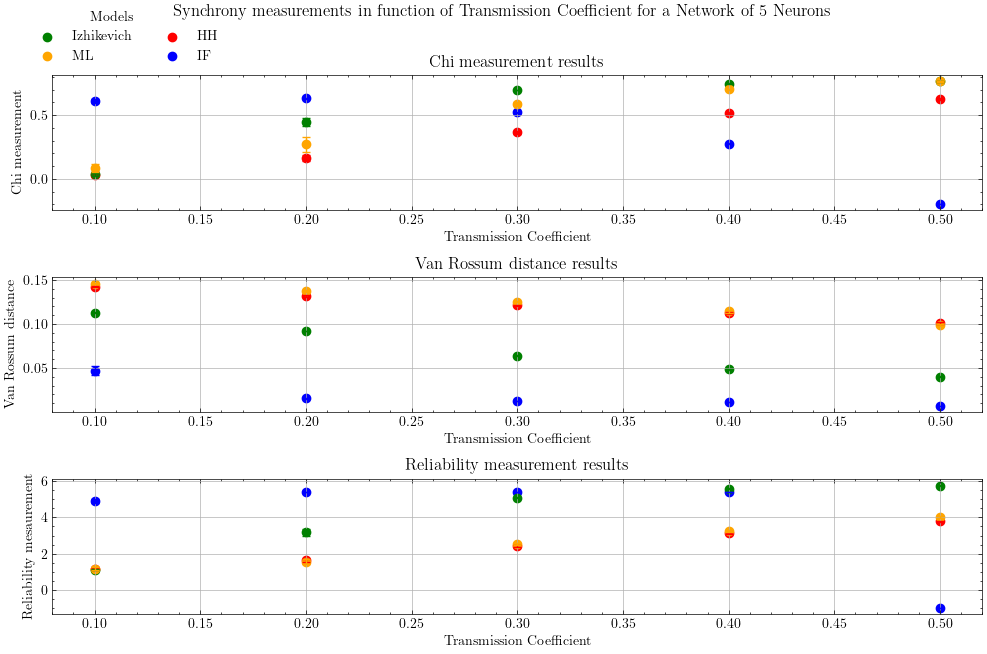

In [60]:
k = np.linspace(0.1,0.5,5)
fig, (ax1, ax2, ax3) = plt.subplots(3,1)

plt.suptitle('Synchrony measurements in function of Transmission Coefficient for a Network of 5 Neurons')
fig.subplots_adjust(hspace=0.5)
ax1.set_xlabel('Transmission Coefficient')
ax2.set_xlabel('Transmission Coefficient')
ax3.set_xlabel('Transmission Coefficient')
ax1.set_ylabel('Chi measurement')
ax2.set_ylabel('Van Rossum distance')
ax3.set_ylabel('Reliability mesaurement')
ax1.tick_params(axis = 'y')
ax2.tick_params(axis = 'y')
ax3.tick_params(axis = 'y')

ax1.title.set_text('Chi measurement results')
ax2.title.set_text('Van Rossum distance results')
ax3.title.set_text('Reliability measurement results')

ln1 = ax1.scatter(k,chi_HH_k[:,0],color = 'r', label = 'HH')
ax1.errorbar(k,chi_HH_k[:,0],yerr=chi_HH_k[:,1], fmt='none',capsize=3,color = 'r')
ln2 = ax1.scatter(k,chi_IF_k[:,0],color = 'b', label = 'IF')
ax1.errorbar(k,chi_IF_k[:,0],yerr=chi_IF_k[:,1], fmt='none',capsize=3,color = 'b')
ln3 = ax1.scatter(k,chi_IZH_k[:,0],color = 'g', label = 'Izhikevich')
ax1.errorbar(k,chi_IZH_k[:,0],yerr=chi_IZH_k[:,1], fmt='none',capsize=3,color = 'g')
ln4 = ax1.scatter(k,chi_ML_k[:,0],color = 'orange', label = 'ML')
ax1.errorbar(k,chi_ML_k[:,0],yerr=chi_ML_k[:,1], fmt='none',capsize=3,color = 'orange')


ax2.scatter(k,rossum_HH_k[:,0],color = 'r', label = 'HH')
ax2.errorbar(k,rossum_HH_k[:,0],yerr=rossum_HH_k[:,1], fmt='none',capsize=3,color = 'r')
ax2.scatter(k,rossum_IF_k[:,0],color = 'b', label = 'IF')
ax2.errorbar(k,rossum_IF_k[:,0],yerr=rossum_IF_k[:,1], fmt='none',capsize=3,color = 'b')
ax2.scatter(k,rossum_IZH_k[:,0],color = 'g', label = 'Izhikevich')
ax2.errorbar(k,rossum_IZH_k[:,0],yerr=rossum_IZH_k[:,1], fmt='none',capsize=3,color = 'g')
ax2.scatter(k,rossum_ML_k[:,0],color = 'orange', label = 'ML')
ax2.errorbar(k,rossum_ML_k[:,0],yerr=rossum_ML_k[:,1], fmt='none',capsize=3,color = 'orange')

ax3.scatter(k,rel_HH_k[:,0],color = 'r', label = 'HH')
ax3.errorbar(k,rel_HH_k[:,0],yerr=rel_HH_k[:,1], fmt='none',capsize=3,color = 'r')
ax3.scatter(k,rel_IF_k[:,0],color = 'b', label = 'IF')
ax3.errorbar(k,rel_IF_k[:,0],yerr=rel_IF_k[:,1], fmt='none',capsize=3,color = 'b')
ax3.scatter(k,rel_IZH_k[:,0],color = 'g', label = 'Izhikevich')
ax3.errorbar(k,rel_IZH_k[:,0],yerr=rel_IZH_k[:,1], fmt='none',capsize=3,color = 'g')
ax3.scatter(k,rel_ML_k[:,0],color = 'orange', label = 'ML')
ax3.errorbar(k,rel_ML_k[:,0],yerr=rel_ML_k[:,1], fmt='none',capsize=3,color = 'orange')


leg  = ax1.legend(title='Models',bbox_to_anchor =( 0.1,1.0), ncols = 2 , mode = 'expand')
leg._legend_box.align = 'right'
plt.show()